In [99]:
!pip install keras
!pip install opencv-python
!pip install tensorflow-addons

     |████████████████████████████████| 1.8MB 2.8MB/s 
     |████████████████████████████████| 380.8MB 40kB/s 
     |████████████████████████████████| 3.8MB 8.9MB/s 
     |████████████████████████████████| 450kB 8.4MB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.2 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Succe

In [28]:
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install tqdm


In [84]:
from google.colab import auth
auth.authenticate_user()

!gsutil cp -r gs://steel-data/data/train.zip /content
!unzip /content/train.zip

Copying gs://steel-data/data/train.zip...
- [1 files][  1.2 GiB/  1.2 GiB]   64.7 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      
Copying gs://steel-data/data/train.csv...
- [1 files][ 17.7 MiB/ 17.7 MiB]                                                
Operation completed over 1 objects/17.7 MiB.                                     
Copying gs://steel-data/data/sample_submission.csv...
/ [1 files][140.7 KiB/140.7 KiB]                                                
Operation completed over 1 objects/140.7 KiB.                                    


In [90]:
!unzip /content/train.zip 

Archive:  /content/train.zip
caution: filename not matched:  /content/train/


In [0]:

import os
import json
import random

import cv2
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout, Conv2DTranspose, MaxPooling2D, concatenate 
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

In [0]:
ONLY_CLASSIFY = True
IMAGE_CHANNELS = 1

## PREPROCESSING

In [63]:
traindf=pd.read_csv('train.csv')
traindf['ImageId'] = traindf['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
traindf['ClassId'] = traindf['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
traindf['hasMask'] = ~ traindf['EncodedPixels'].isna()
traindf.head()

,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


In [64]:
maskcountdf = traindf.groupby('ImageId').agg(np.sum).reset_index()
maskcountdf.sort_values('hasMask', ascending=False, inplace=True)
print(maskcountdf.shape)
maskcountdf.head()

(12568, 2)


,ImageId,hasMask
10803,db4867ee8.jpg,3.0
11776,ef24da2ba.jpg,3.0
6284,7f30b9c64.jpg,2.0
9421,bf0c81db6.jpg,2.0
9615,c314f43f3.jpg,2.0


In [0]:
sub_df = pd.read_csv('sample_submission.csv')
sub_df['ImageId'] = sub_df['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(sub_df['ImageId'].unique(), columns=['ImageId'])

## UTILITY

In [0]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle2mask(mask_rle, shape=(256,1600)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

In [0]:
def build_masks(rles, input_shape):
    depth = len(rles)
    height, width = input_shape
    masks = np.zeros((height, width, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            masks[:, :, i] = rle2mask(rle, (width, height))
    
    return masks

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles

def rles_classvect(rles):
    depth = 2
    masks = np.zeros((depth))
    masks[0] = 1
    masks[1] = 0
    for i, rle in enumerate(rles):
      if type(rle) is str:
          masks[0] = 0
          masks[1] = 1
    return masks

def random_flip(img):
  seed = random.randint(1,5)
  if seed % 3 == 0:
    img = np.flip(img, 0)
  if seed % 4 == 0:
    img = np.flip(img, 1)
  return img

In [0]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

## Sample

TypeError: ignored

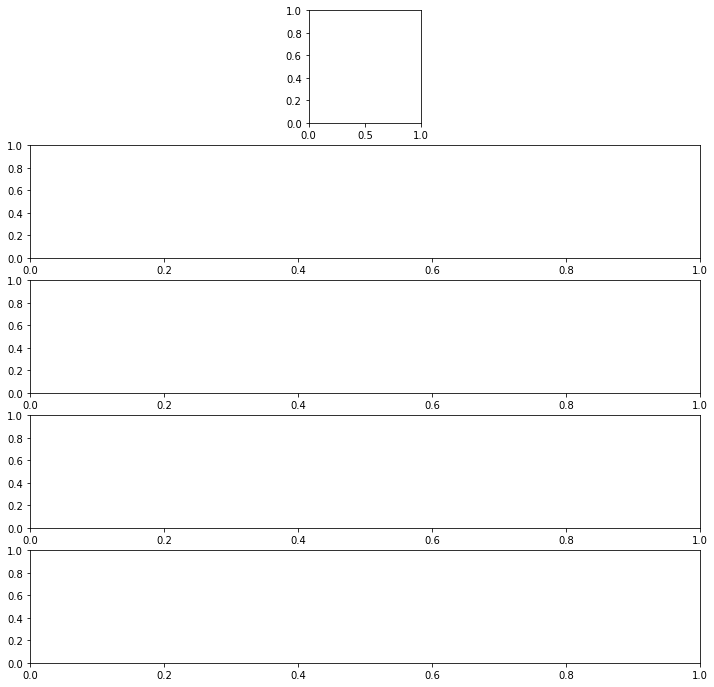

In [69]:
#/kaggle/input/severstal-steel-defect-detection/train_images/910540b7d.jpg
sample_filename = '910540b7d.jpg'
sample_image_df = traindf[traindf['ImageId'] == sample_filename]
sample_path = f"{sample_image_df['ImageId'].iloc[0]}"
sample_img = cv2.imread(sample_path)
sample_rles = sample_image_df['EncodedPixels'].values
sample_masks = build_masks(sample_rles, input_shape=(256, 1600))

fig, axs = plt.subplots(5, figsize=(12, 12))
axs[0].imshow(sample_img)
axs[0].axis('off')

for i in range(4):
    axs[i+1].imshow(sample_masks[:, :, i])
    axs[i+1].axis('off')

## Data Generation

In [0]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='/content/train_images',
                 batch_size=32, dim=(256, 1600), n_channels=1,
                 n_classes=2, random_state=2019, shuffle=True, 
                 classify=False):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        self.classify = classify
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch, self.classify)
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}"
            if self.n_channels == 3:
              img = self.__load_rgb(img_path)
            else:
              img = self.__load_grayscale(img_path)
            img = random_flip(img)
            
            # Store samples
            X[i,] = img
        return X

    def __generate_y(self, list_IDs_batch, classify=False):
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        if classify:
          y = np.empty((self.batch_size, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            rles = image_df['EncodedPixels'].values
            if classify:
              masks = rles_classvect(rles)
            else:
              masks = build_masks(rles, input_shape=self.dim)
            y[i, ] = masks
        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.
        return img


In [0]:
BATCH_SIZE = 16

train_idx, val_idx = train_test_split(
    maskcountdf.index, random_state=2019, test_size=0.15
)

train_generator = DataGenerator(
    train_idx, 
    df=maskcountdf,
    target_df=traindf,
    batch_size=BATCH_SIZE, 
    n_classes=2,
    n_channels=IMAGE_CHANNELS,
    classify=ONLY_CLASSIFY
)

val_generator = DataGenerator(
    val_idx, 
    df=maskcountdf,
    target_df=traindf,
    batch_size=BATCH_SIZE, 
    n_classes=2,
    n_channels=IMAGE_CHANNELS,
    classify=ONLY_CLASSIFY
)

In [0]:
def F1Score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
def build_model(input_shape):
    inputs = Input(input_shape)

    weight_decay = 1e-3

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)) (inputs)
    #c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    b1 = BatchNormalization() (c1)
    p1 = MaxPooling2D((2, 2)) (b1)
    

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)) (p1)
    #c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    b2 = BatchNormalization() (c2)
    p2 = MaxPooling2D((2, 2)) (b2)
    

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)) (p2)
    #c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    b3 = BatchNormalization() (c3)
    p3 = MaxPooling2D((2, 2)) (b3)
    #d3 = Dropout(0.3) (p3)

    c4 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)) (p3)
    #c4 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    b4 = BatchNormalization() (c4)
    p4 = MaxPooling2D((2, 2)) (b4)

    c5 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay)) (p4)
    b5 = BatchNormalization() (c5)
    #c5 = Conv2D(8, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D((2, 2)) (b5)
    #d5 = Dropout(0.3) (p5)

    f6 = Flatten() (p5)
    #d6 = Dense(16, activation='softmax') (f6)
    d6 = Dense(2, activation='softmax') (f6)

    outputs = d6

    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(
        optimizer=keras.optimizers.SGD(), 
        loss=keras.losses.categorical_crossentropy, 
        metrics=[F1Score])
    return model

In [97]:
model = build_model((256, 1600, 1))
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 1600, 1)]    0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 256, 1600, 8)      80        
_________________________________________________________________
batch_normalization_40 (Batc (None, 256, 1600, 8)      32        
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 128, 800, 8)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 128, 800, 16)      1168      
_________________________________________________________________
batch_normalization_41 (Batc (None, 128, 800, 16)      64        
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 64, 400, 16)       0   

In [98]:
checkpoint = ModelCheckpoint(
    'simple_cnn_reg_model.h5', 
    monitor='F1Score', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

history = model.fit_generator(
    train_generator,
    validation_data=val_generator,
    callbacks=[checkpoint],
    use_multiprocessing=True,
    epochs=70
)

Epoch 1/70
667/667 [==============================] - 300s 449ms/step - loss: 0.8683 - F1Score: 0.6634 - val_loss: 0.7331 - val_F1Score: 0.6683
Epoch 2/70
667/667 [==============================] - 298s 446ms/step - loss: 0.5980 - F1Score: 0.7329 - val_loss: 0.5983 - val_F1Score: 0.7436
Epoch 3/70
667/667 [==============================] - 297s 445ms/step - loss: 0.5387 - F1Score: 0.7677 - val_loss: 0.7169 - val_F1Score: 0.6725
Epoch 4/70
667/667 [==============================] - 298s 447ms/step - loss: 0.5000 - F1Score: 0.7974 - val_loss: 0.4993 - val_F1Score: 0.7874
Epoch 5/70
667/667 [==============================] - 297s 446ms/step - loss: 0.4772 - F1Score: 0.8072 - val_loss: 0.5442 - val_F1Score: 0.7639
Epoch 6/70
667/667 [==============================] - 298s 447ms/step - loss: 0.4503 - F1Score: 0.8228 - val_loss: 0.9989 - val_F1Score: 0.6859
Epoch 7/70
667/667 [==============================] - 298s 446ms/step - loss: 0.4301 - F1Score: 0.8349 - val_loss: 0.9937 - val_F1Score:

In [0]:
model.save('/content/simple_cnn_reg_model.h5')